# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

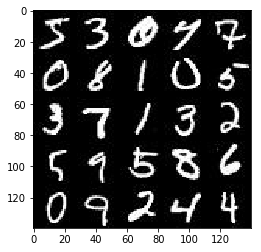

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

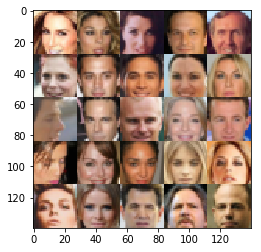

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\rsemenov\AppData\Local\Continuum\Anaconda3\envs\dlnd\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, (), name="learn_rate")

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 14x14x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # 7x7x256
        flat = tf.reshape(relu3, (-1, 7*7*256)) 
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # fully connected
        x1 = tf.layers.dense(z, (7*7*256))
        
        # reshape to start the conv
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1) #leaky relu

        # 7x7x256
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2) #leaky relu
        
        # 14x14x128
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3) #leaky relu
    
        # 14x14x64
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]

    # optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_channels = 1 if data_image_mode == "L" else 3
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[1], img_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images*2
                # random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 5 == 0:
                    # get train losses and print
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # save losses to view after training
                    # losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.6816... Generator Loss: 7.6535
Epoch 1/2... Discriminator Loss: 1.6397... Generator Loss: 1.8041
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 3.8264


KeyboardInterrupt: 

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.1871... Generator Loss: 0.1426
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.9031... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 3.6766
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 5.4016
Epoch 1/1... Discriminator Loss: 2.2830... Generator Loss: 6.9570
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 2.1655
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 2.7369
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 2.4683
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.3672
Epoch 1/1.

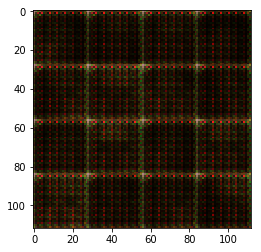

Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 3.3123
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 2.3637
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 2.2503
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.9756... Generator Loss: 0.2821
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.4053
Epoch 1/1.

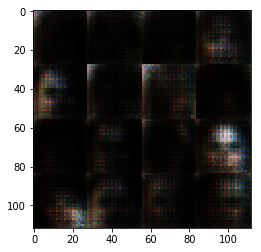

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 2.7559
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.7379... Generator Loss: 0.3909
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 2.6038
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.8786
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7105
Epoch 1/1.

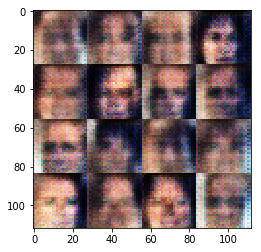

Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9861
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.0222
Epoch 1/1.

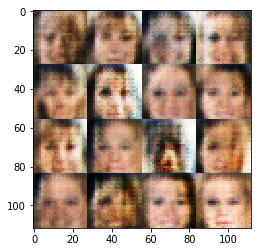

Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 1.0909
Epoch 1/1.

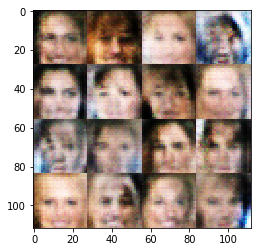

Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 1.1433
Epoch 1/1.

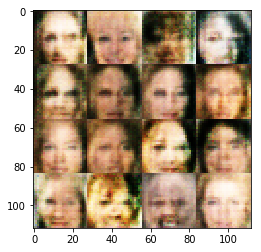

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 1.0630
Epoch 1/1.

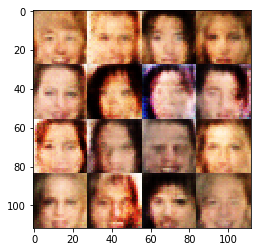

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.0268
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 1.0875
Epoch 1/1.

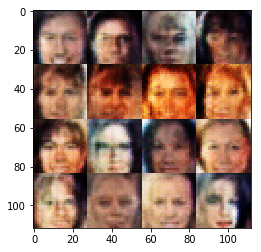

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 1.7827
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7248
Epoch 1/1.

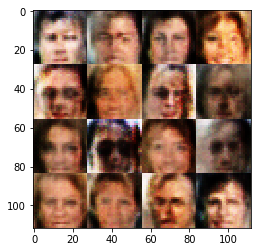

Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 2.0132
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.8967... Generator Loss: 3.2279
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6322
Epoch 1/1.

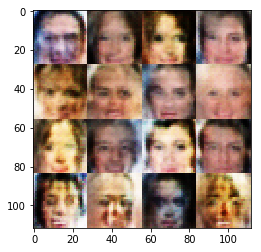

Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.5908
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.7116
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.4792
Epoch 1/1.

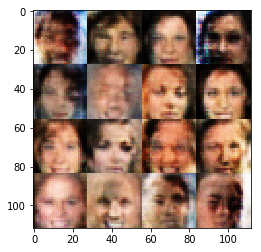

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.4974
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 3.4039
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 2.3770
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7560
Epoch 1/1.

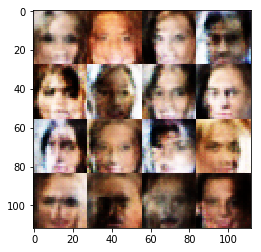

Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 3.1965
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 2.0866
Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 3.0535
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 2.9261
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.9101
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 2.8399
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.4647
Epoch 1/1.

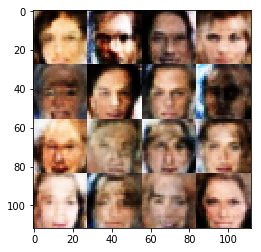

Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.8428


KeyboardInterrupt: 

In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.